# Identifying Humpback Whale Individuals by their Fluke Patterning

First, we pip-install any packages we will need beyond the usual:

In [25]:
# ! pip3 install kaggle --upgrade --user
# ! pip3 install pandas --user
# ! pip3 install seaborn --user

Before running the below command, go to Kaggle and sign in. If you get a 404 Error, go to the download data page for the competition and accept the terms of the agreement. 

https://www.kaggle.com/c/whale-categorization-playground/data

Now, we import everything that we will need:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import conx as cx

Using TensorFlow backend.
ConX, version 3.7.6


We set some global variables, including the path to download and install the images, and the size that we will use to make the images small, and consistent:

In [2]:
PROJECT_PATH = '~/Desktop/WhaleTailChallenge/'
RESIZE = (100,100) ## start out small

If the PROJECT_PATH doesn't exist, we create it, and make the kaggle file have proper permissions:

In [69]:
# ! mkdir -p {PROJECT_PATH}
# ! chmod 600 ~/.kaggle/kaggle.json

Download the data to your working directory:

In [4]:
# ! kaggle competitions download -c whale-categorization-playground -p {PROJECT_PATH}
# ! unzip ~/Desktop/WhaleTailChallenge/test.zip

We use pandas to read the training data:

In [5]:
ann = pd.read_csv((PROJECT_PATH + 'train.csv'))

In [6]:
print('There are {} unique whales in the training set.'.format(len(ann.Id.unique())))
print('{0:.1f}% of the individuals are pictured only 1 time.'.format(
    (ann.Id.value_counts()==1).sum()/len(ann.Id.unique()) * 100))
print('{0:.1f} % of the photos are completely new whales.'.format(
    100 * len(ann.loc[ann['Id'] == 'new_whale']) / len(ann['Id'])))

There are 4251 unique whales in the training set.
52.2% of the individuals are pictured only 1 time.
8.2 % of the photos are completely new whales.


Let's look at the first image:

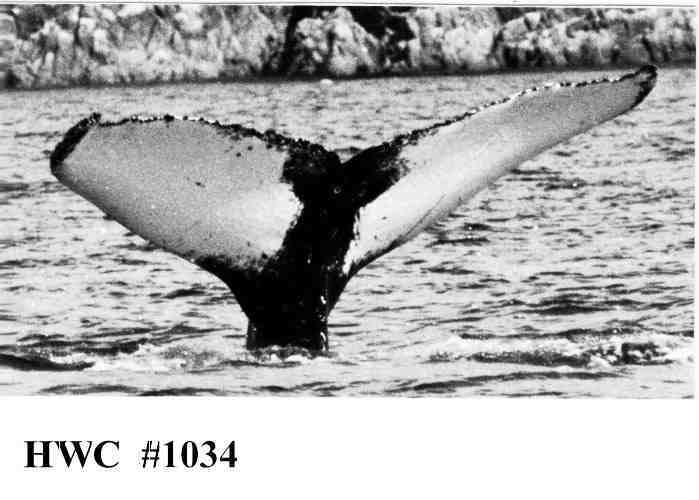

In [7]:
cx.image(PROJECT_PATH + "/train/" + ann.Image[0])

Weird! It has a label in the image. This is not going to be an easy task with such dirty data. We could clean this up a bit with:

In [71]:
cx.image(PROJECT_PATH + "/train/" + ann.Image[0]).size

(699, 500)

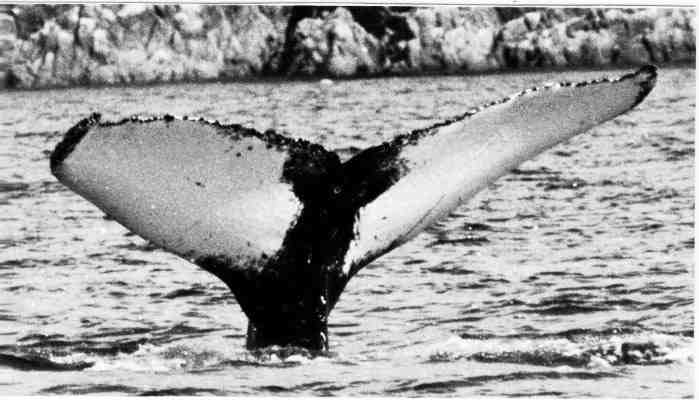

In [73]:
cx.crop_image(cx.image(PROJECT_PATH + "/train/" + ann.Image[0]), 0,0, 699,400)

For now, let's just look at some more images:

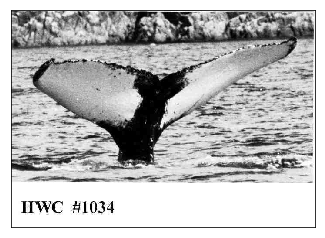

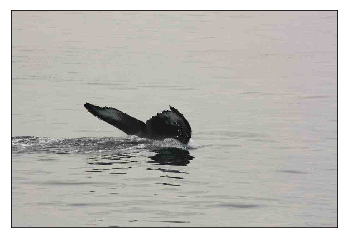

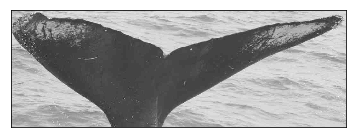

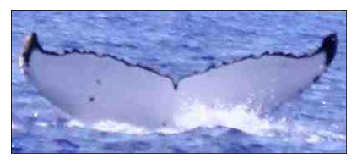

In [74]:
for i in range(4):
    cx.view(PROJECT_PATH + "/train/" + ann.Image[i])

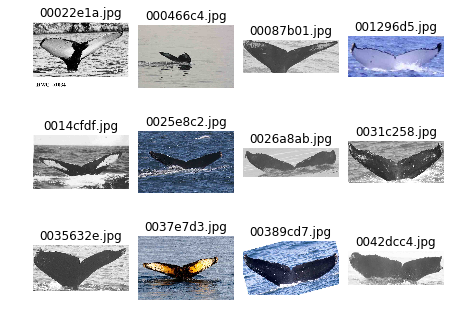

In [11]:
cx.view([f'{PROJECT_PATH}/train/{filename}' for filename in ann.Image[:12]], 
        labels=ann.Image[:12], scale=1.5)

Most common whale:

In [6]:
ann.Id.value_counts().index[1]

'w_1287fbc'

In [7]:
matching_images = ann.loc[ann['Id']== ann.Id.value_counts().index[1], 'Image']

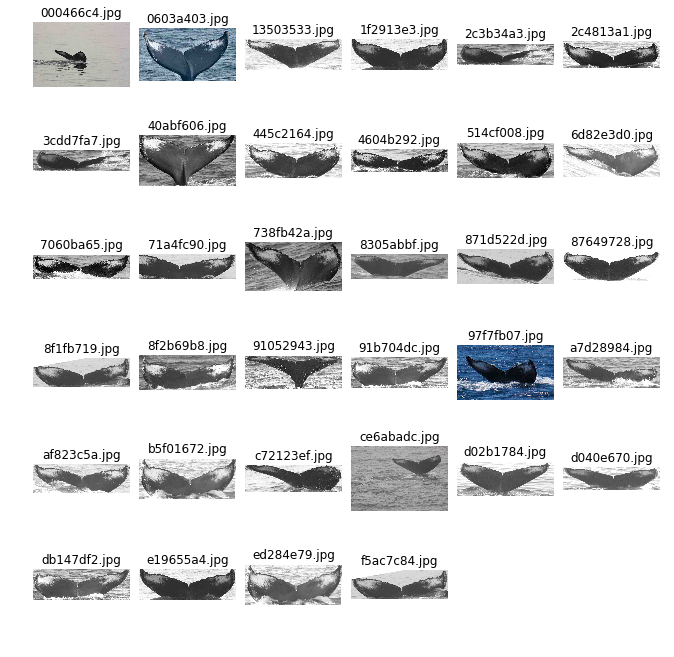

In [8]:
cx.view([f'{PROJECT_PATH}/train/{filename}' for filename in matching_images], 
        labels=matching_images, scale=1.5)

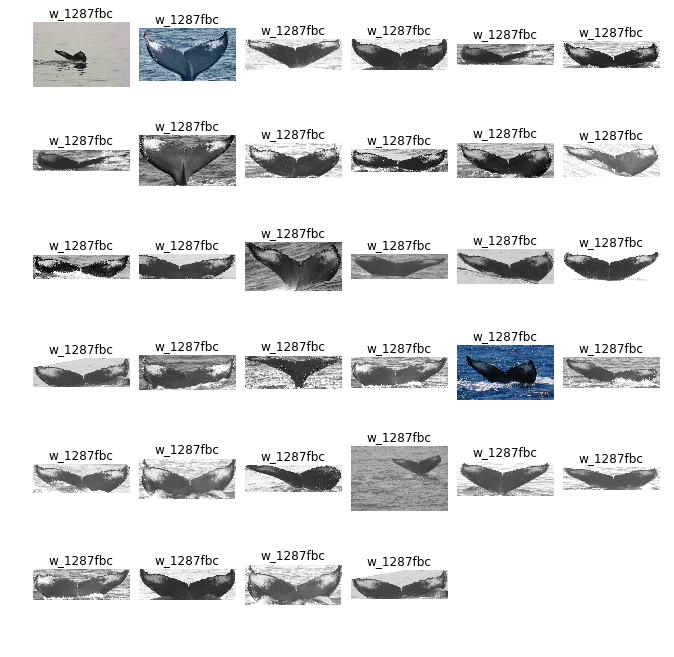

In [9]:
my_labels = ann.loc[ann['Image'].isin(matching_images.values), 'Id']
cx.view([f'{PROJECT_PATH}/train/{filename}' for filename in matching_images], 
        labels=my_labels, scale=1.5)

Let's make the inputs for the network. For now, we'll make them (100,100) grayscale:

In [25]:
%%time
inputs = [cx.image_to_array(cx.image(f'{PROJECT_PATH}/train/{filename}', 
                                     gray=True, 
                                     resize=RESIZE))
          for filename in ann.Image]

CPU times: user 31.6 s, sys: 837 ms, total: 32.4 s
Wall time: 32.4 s


In [26]:
cx.shape(inputs)

(9850, 100, 100)

There are almost 10k images. Let's check that first one by turning it back into an image:

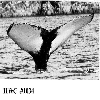

In [27]:
cx.array_to_image(inputs[0])

Looks good! Now, let's get the set of targets:

In [87]:
id_to_target = {id: index for (index, id) in enumerate(set(ann.Id))}

In [88]:
len(set(ann.Id))

4251

And make the targets:

In [93]:
targets = [cx.onehot(id_to_target[id],4251) for id in ann.Id]

In [116]:
cx.find_dimensions(4251)

[65, 66]

In [94]:
net = cx.Network("WhaleTail Network")
net.add(
    cx.Layer("input", RESIZE + (1,)), ## 3D
    cx.Conv2DLayer("conv1", 16, (5,5), activation="relu", dropout=0.20),
    cx.MaxPool2DLayer("maxpool1", (2,2)),
    cx.Conv2DLayer("conv2", 32, (5,5), activation="relu", dropout=0.20),
    cx.MaxPool2DLayer("maxpool2", (2,2)),
    cx.FlattenLayer("flatten"),
    cx.Layer("hidden", 100, activation='relu'),
    cx.Layer("output", 4251, vshape=(39, 109), activation='softmax'),
);
net.connect()

In [95]:
%%time
net.dataset.load(inputs=inputs, targets=targets)

CPU times: user 8.53 s, sys: 109 ms, total: 8.64 s
Wall time: 8.63 s


In [96]:
net.dataset.inputs.shape

[(100, 100)]

In [97]:
net.dataset.inputs.reshape(0, (100, 100, 1))

In [98]:
net.dataset.inputs.shape

[(100, 100, 1)]

In [99]:
net.compile(error="categorical_crossentropy", optimizer="rmsprop")

In [122]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

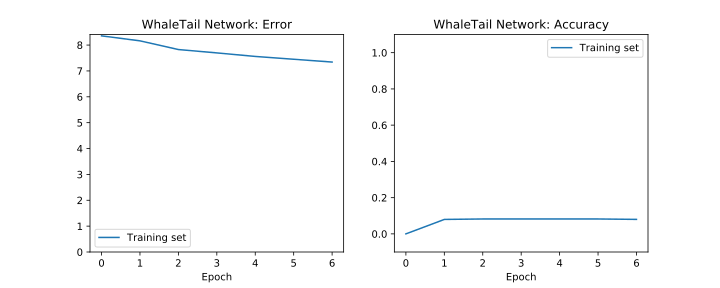

Interrupted! Cleaning up...
       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#    6 |   7.34207 |   0.08000 


KeyboardInterrupt: 

In [124]:
net.train(10)